In [242]:
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights, convnext_base, ConvNeXt_Base_Weights, swin_v2_b, Swin_V2_B_Weights, mobilenet_v3_large, MobileNet_V3_Large_Weights
from pathlib import Path
import matplotlib.pyplot as plt 
from torchvision.transforms import v2
from torchvision.io import decode_image
import torch
from torchvision import tv_tensors, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

In [ ]:
#intialize the models 
resnet_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
conv_model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)
swin_model = swin_v2_b(weights=Swin_V2_B_Weights.IMAGENET1K_V1)
mobile_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)

In [233]:
image_dir = "../DataCleaning/Sorted_Images/BCC/s-prd-416761910.jpg"

In [234]:
data_dir = "../DataCleaning/Sorted_Images"

In [235]:
img = decode_image(str(Path(image_dir)))

In [236]:
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 4032, 3024])


In [237]:
# this cell taken from helpers.py from pytorch 
from torchvision.utils import draw_bounding_boxes, draw_keypoints, draw_segmentation_masks
from torchvision.transforms.v2 import functional as F

def plot(imgs, row_title=None, bbox_width=3, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            points = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target

                    # Conversion necessary because draw_bounding_boxes() only
                    # work with this specific format.
                    if tv_tensors.is_rotated_bounding_format(boxes.format):
                        boxes = v2.ConvertBoundingBoxFormat("xyxyxyxy")(boxes)
                elif isinstance(target, tv_tensors.KeyPoints):
                    points = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=bbox_width)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)
            if points is not None:
                img = draw_keypoints(img, points, colors="red", radius=10)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [238]:
transform = v2.Compose(
    [
        v2.RandomResizedCrop(size=(224, 244), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
out = transform(img)

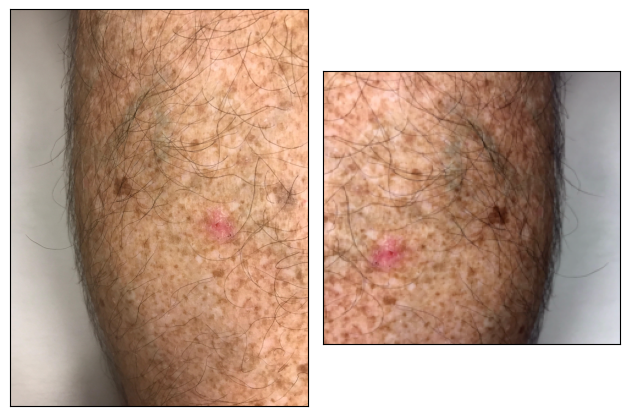

In [241]:
plot([img, out])

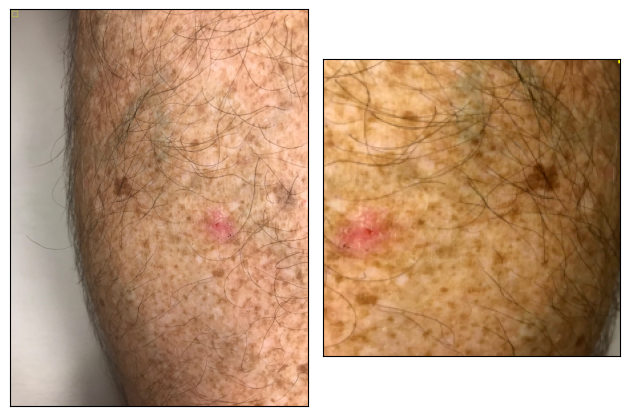

In [211]:
boxes = tv_tensors.BoundingBoxes(
    [
        [20, 20, 80, 80],
    
    ],
    format="XYXY", canvas_size=img.shape[-2:])

transforms2 = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])

out_img, out_boxes = transforms2(img, boxes)

plot([(img, boxes), (out_img, out_boxes)])

Need to train and test models on metrics thinking precision, recall, f1, f2, roc-auc, confusion matrix, auc-pr.

Pretty heavy class imbalance with 
Melanoma: 234 images
BCC: 594 images
SCC: 365 images
Actinic Keratosis: 176 images
Benign_or_Other: 1786 images 
Total: 3155 

So lower classes we need to augment them much heavier than benign and use random weighted sampling as well as focal loss so model doesn't over focus on benign cases and lose focus on smaller cases.



In [259]:
# Focal Loss implementation from https://github.com/itakurah/focal-loss-pytorch/blob/main/focal_loss.py 

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [243]:
training_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# metric imports 
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,  # f2 score
    roc_auc_score,
    average_precision_score,  # auc-pr 
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve
)

In [245]:
full_dataset = ImageFolder(root=data_dir, transform=training_transform)

In [246]:
train_size = int(0.80 * len(full_dataset)) #80% train
val_size = int(0.10 * len(full_dataset)) #10% val
test_size = len(full_dataset) - train_size - val_size #rest test

In [247]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(48)
)

In [248]:
print(f"Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Train=2524, Val=315, Test=316


In [250]:
all_labels = [full_dataset[i][1] for i in range(len(full_dataset))]

In [251]:
train_labels = [full_dataset[idx][1] for idx in train_dataset.indices]

In [252]:
# we use multi class -> 5 classes, alpha = class weights calculated by weight_class = total_samples / (num_classes x total_class_count)
# AK = 3155 / (5 x 176)
#    = 3.585 for example, so its weighted the heaviest due to it having the least amount of entries in our data
# Benign = 3155 / (5 x 1786)
#        = 0.353

class_counts = {
    0: 176,   # Actinic Keratosis
    1: 594,   # BCC
    2: 1786,  # Benign
    3: 234,   # Melanoma
    4: 365    # SCC
}

num_classes = 5
total_samples = sum(class_counts.values())

# calculate class weights (inverse frequency)
class_weights = []
for i in range(num_classes):
    weight = total_samples / (num_classes * class_counts[i])
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights)

print("class weights calculated:")
for i, weight in enumerate(class_weights):
    print(f"  Class {i}: {weight:.4f} (count: {class_counts[i]})")
    

class weights calculated:
  Class 0: 3.5852 (count: 176)
  Class 1: 1.0623 (count: 594)
  Class 2: 0.3533 (count: 1786)
  Class 3: 2.6966 (count: 234)
  Class 4: 1.7288 (count: 365)


In [253]:
sample_weights = [class_weights[label] for label in train_labels]

In [254]:
# weighted sampling example 
sampler = WeightedRandomSampler(
    weights=class_weights_tensor,
    num_samples=len(sample_weights),
    replacement=True
)

In [255]:
batch_size = 32

In [257]:
# loading time 
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    sampler=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=False,
    num_workers=0,
    pin_memory=True
)

In [260]:
# focal loss 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = FocalLoss(
    gamma=2.0,
    alpha=class_weights_tensor.to(device=device),  
    reduction='mean',
    task_type='multi-class',
    num_classes=num_classes
)

In [262]:
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device=device)

In [263]:
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)

In [ ]:
# training time 

num_epochs = 5 

for epoch in range(num_epochs):

    resnet_model.train()
    train_loss = 0.0
    correct = 0 
    total = 0 

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # forward pass 
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #stats
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%")
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total 

    #validation
    resnet_model.eval()
    val_loss = 0.0
    correct = 0 
    total = 0 

    with torch.no_grad():
        for images, labels in val_loader: # bug here 
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")